<p style="color:yellow;font-size:18px;"><b>
Tanut Bumrungvongsiri  63340500026 <br>
Parapat patcharapimpisut 63340500046<br>
Ronnakon mekvimanloi 63340500051


# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [1]:
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

In [2]:
# import tensorflow as tf
# print(tf.__version__)

# import matplotlib
# import matplotlib.font_manager as fm

# fm.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
# matplotlib.rc('font', family='TH Sarabun New')

In [3]:
# %matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# import shutil
# shutil.copy("/content/drive/MyDrive/mp_name_th_en.csv", "/content/mp_name_th_en.csv")

In [6]:
import csv

with open('Dataset/mp_name_th_en.csv', 'r', encoding='utf-8') as file:
    readCSV = csv.reader(file)
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [7]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)

In [8]:
def unique_char(words,output =0):
    dictionary = {}
    dictionary["<PAD>"] = 0
    index = 1
    for word in words:
        for char in set(word):
            if char not in dictionary:
                dictionary[char] = index
                index += 1
    if output==1:
        dictionary["<END>"] = index
    return dictionary

def reverse_dict(dictionary):
    rev_dict = {}
    for index,word in enumerate(dictionary):
        rev_dict[index] = word
    return rev_dict

dict_in = unique_char(name_th)
dict_out = unique_char(name_en,1)
print(dict_in)
print(dict_out)

dict_in_rev = reverse_dict(dict_in)
dict_out_rev = reverse_dict(dict_out)
print(dict_in_rev)
print(dict_out_rev)

maxlen_in = len( max(name_th, key=len)) 
maxlen_out = len( max(name_en, key=len)) 

vocab_size_in = len(dict_in)
vocab_size_out = len(dict_out)

def data_generator(dictionary,dataset,maxlen,output):
    data = []
    for word in dataset:
        temp=[]
        for char in word:
            temp.append(dictionary[char])
        if output == 1:
            temp.append(dictionary['<END>'])
        data.append(temp)

    data = pad_sequences(data,maxlen=maxlen,padding='pre')
    return data

X = data_generator(dict_in,name_th,maxlen_in,0)
Y = data_generator(dict_out,name_en,maxlen_out,1)

X= to_categorical(X,vocab_size_in)
X=X.reshape(len(name_th),maxlen_in ,vocab_size_in)

Y= to_categorical(Y,vocab_size_out)
Y=Y.reshape(len(name_en),maxlen_out ,vocab_size_out)
print(X.shape,Y.shape) 

{'<PAD>': 0, 'ร': 1, 'ส': 2, 'ี': 3, 'ห': 4, 'ก': 5, '์': 6, 'ไ': 7, 'พ': 8, 'ช': 9, 'ั': 10, 'ธ': 11, 'ะ': 12, 'ิ': 13, 'ว': 14, 'ฒ': 15, 'ุ': 16, 'ณ': 17, 'ภ': 18, ' ': 19, 'า': 20, 'ษ': 21, 'ม': 22, 'ศ': 23, 'น': 24, 'ท': 25, 'ด': 26, 'ย': 27, 'อ': 28, 'เ': 29, 'ค': 30, 'ต': 31, '่': 32, 'ำ': 33, 'ฐ': 34, 'ญ': 35, 'ล': 36, 'ู': 37, 'ง': 38, 'ฏ': 39, 'ป': 40, 'บ': 41, 'ฎ': 42, 'จ': 43, 'โ': 44, 'ข': 45, 'ื': 46, 'ึ': 47, 'ถ': 48, '้': 49, 'ซ': 50, 'ฑ': 51, 'แ': 52, 'ผ': 53, '็': 54, 'ฮ': 55, 'ฉ': 56, 'ใ': 57, '๊': 58, 'ฆ': 59, 'ฌ': 60, 'ฟ': 61, 'ฬ': 62, 'ฝ': 63, '๋': 64}
{'<PAD>': 0, 'k': 1, 'i': 2, 's': 3, 'a': 4, 'r': 5, 't': 6, 'h': 7, 'p': 8, 'u': 9, 'n': 10, 'o': 11, 'w': 12, 'm': 13, 'd': 14, 'e': 15, 'c': 16, 'l': 17, 'g': 18, 'y': 19, 'b': 20, 'f': 21, '-': 22, '<END>': 23}
{0: '<PAD>', 1: 'ร', 2: 'ส', 3: 'ี', 4: 'ห', 5: 'ก', 6: '์', 7: 'ไ', 8: 'พ', 9: 'ช', 10: 'ั', 11: 'ธ', 12: 'ะ', 13: 'ิ', 14: 'ว', 15: 'ฒ', 16: 'ุ', 17: 'ณ', 18: 'ภ', 19: ' ', 20: 'า', 21: 'ษ', 22: 'ม', 23:

# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* Hint: you will probably need more hidden dimmensions than what you've seen in the demo


In [9]:
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Lambda
from tensorflow import split
def softMaxAxis1(x):
    return softmax(x,axis=1)


In [10]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template. 

#repeater = ???
#concatenator = ???

repeator = RepeatVector(maxlen_in)
concatenator = Concatenate(axis=-1)

#Key-values (Hint)
splitter = Lambda(lambda x:split(x, num_or_size_splits=2,axis=2)) 

#fatten_1 = ???
#fatten_2 = ???

fattn_1 = Dense(128, activation = "tanh")
fattn_2 = Dense(1, activation = "tanh")

#activator = ???
#dotor = ???

activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)

In [11]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    
    key , value = splitter(a)

    #concat = ...key...
    concat = concatenator([key,s_prev])
    e = fattn_1(concat)
    energies = fattn_2(e)
    attention_scores = activator(energies)
    #context = ...value...
    context = dotor([attention_scores,value])


    return context , attention_scores ,energies  # return whatever you need to complete this homework 

## Task3: Create and train your encoder/decoder model here
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [12]:
n_h = 64 #hidden dimensions for encoder 
n_s = 128 #hidden dimensions for decoder
Tx , Ty = maxlen_in, maxlen_out

encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(vocab_size_out, activation="softmax") #softmax output layer

In [13]:
#FILL CODE HERE :Hint --> heatmap in CNN + GradCAM

def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()

    #Encoder Bi-LSTM
    # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context , attention_scores ,energies = one_step_attention(h, s)
       
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
           
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

def inference_encoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, vocab_size))

    h = encoder_LSTM(X)

    model = Model(inputs=[X],outputs=h)

    return model

def inference_decoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    h = Input(shape=(Tx,n_h*2), name='h')
    s = s0
    c = c0

    context, attention_scores, energies = one_step_attention(h, s)

    s, _, c = decoder_LSTM_cell(context, initial_state=[s, c])

    out = output_layer(s)

    model = Model(inputs=[h, s0, c0], outputs=[out, s, c, attention_scores, energies])

    return model



In [14]:
#FIT YOUR MODEL HERE

model = model(maxlen_in, maxlen_out, n_h, n_s, vocab_size_in, vocab_size_out)

In [15]:
# model.summary()

In [16]:
opt = Adam(learning_rate= 0.01, clipvalue=0.5)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

s0 = np.zeros((len(name_th), n_s))
c0 = np.zeros((len(name_th), n_s))
outputs = list(Y.swapaxes(0,1))

model.fit([X, s0, c0], outputs, epochs=30, batch_size= 64)

171/171 [==============================] - 51s 75ms/step - loss: 25.5984 - dense_2_loss: 0.1320 - dense_2_1_loss: 0.1111 - dense_2_2_loss: 0.1067 - dense_2_3_loss: 0.1137 - dense_2_4_loss: 0.1392 - dense_2_5_loss: 0.1890 - dense_2_6_loss: 0.2806 - dense_2_7_loss: 0.4327 - dense_2_8_loss: 0.7132 - dense_2_9_loss: 1.1105 - dense_2_10_loss: 1.6361 - dense_2_11_loss: 2.2209 - dense_2_12_loss: 2.6509 - dense_2_13_loss: 2.8660 - dense_2_14_loss: 2.8717 - dense_2_15_loss: 3.1306 - dense_2_16_loss: 2.7705 - dense_2_17_loss: 2.7607 - dense_2_18_loss: 1.3624 - dense_2_accuracy: 0.9938 - dense_2_1_accuracy: 0.9931 - dense_2_2_accuracy: 0.9922 - dense_2_3_accuracy: 0.9908 - dense_2_4_accuracy: 0.9865 - dense_2_5_accuracy: 0.9782 - dense_2_6_accuracy: 0.9605 - dense_2_7_accuracy: 0.9299 - dense_2_8_accuracy: 0.8621 - dense_2_9_accuracy: 0.7573 - dense_2_10_accuracy: 0.5978 - dense_2_11_accuracy: 0.3955 - dense_2_12_accuracy: 0.2387 - dense_2_13_accuracy: 0.1562 - dense_2_14_accuracy: 0.1589 - dense

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! 
* Task 5: Show your visualization of attention scores on one of your example 

In [25]:
#task 4
#fill your code here
def prep_input(input_list):
    X = []
    for line in input_list:
        temp=[]
        for char in line:
            temp.append(dict_in[char])
        X.append(temp)
    X = pad_sequences(X,maxlen=maxlen_in)
    X= to_categorical(X,len(dict_in))
    X=X.reshape(len(input_list),maxlen_in ,len(dict_in))
    
    return X

EXAMPLES = ['สมชาย','สมศักดิ์','อดัม','ก้องภพ','ธนัท','ใจดี']
Sample = EXAMPLES
s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
EXAMPLES = prep_input(EXAMPLES)

prediction = model.predict([EXAMPLES , s0, c0])
prediction = np.swapaxes(prediction,0,1)
prediction = np.argmax(prediction, axis = -1)

for j in range(len(prediction)):
    output = "".join([dict_out_rev[int(i)] for i in prediction[j]])
    output = output.replace('<PAD>','')
    output = output.replace('<END>','')
    print(Sample[j],output)  

1/1 [==============================] - 0s 36ms/step
สมชาย aaaaa
สมศักดิ์ aaaaa
อดัม aaa
ก้องภพ aahhhaa
ธนัท aaaaaa
ใจดี aaaa


### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
--> https://drive.google.com/file/d/168J5SPSf4NNKj718wWUEDpUbh8QYZKux/view?usp=share_link

In [18]:
# EXAMPLES = ???
# h = inferEncoder_model.predict(EXAMPLES)
# s0 = ???
# c0 = ???
# ...
# Ty = 10
# for t in range(Ty):
#   out,s,c,attention_scores,energies = inferDecoder_model.predict([h,s0,c0])
# ...

EXAMPLES = ['สมชาย','สมศักดิ์','อดัม','ก้องภพ','ธนัท','ใจดี']
temp = EXAMPLES
inferEncoder_model = inference_encoder(maxlen_in, maxlen_out, n_h, n_s, vocab_size_in, vocab_size_out)
inferDecoder_model = inference_decoder(maxlen_in, maxlen_out, n_h, n_s, vocab_size_in, vocab_size_out)

s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
s = s0
c = c0

EXAMPLES = prep_input(EXAMPLES)
h = inferEncoder_model.predict(EXAMPLES,verbose=0)

Ty = 30
score = []
attention_list = []

for t in range(Ty):
    out,s,c,attention_scores,energies = inferDecoder_model.predict([h,s,c],verbose=0)
    score.append(out)
    attention_list.append(attention_scores)
    print("attention_scores : ",attention_scores)
    # array=np.array(out)
    
prediction = np.swapaxes(score,0,1)
prediction = np.argmax(prediction, axis = -1)

attention_list = np.array(attention_list)
output_list=[]

for j in range(len(prediction)):
    a = [dict_out_rev[int(i)] for i in prediction[j]]
    output = "".join(a)
    output_list.append([[temp[j]],a])
    # output = output.replace('<PAD>','')
    # output = output.replace('<END>','')
    print(temp[j],output)  

attention_scores :  [[[0.05413901]
  [0.05812895]
  [0.05854526]
  [0.05771978]
  [0.0566581 ]
  [0.05571264]
  [0.05496661]
  [0.05440804]
  [0.05399995]
  [0.05370533]
  [0.05349406]
  [0.0533434 ]
  [0.05323658]
  [0.05316145]
  [0.05310912]
  [0.03281547]
  [0.03130113]
  [0.04152688]
  [0.03574078]
  [0.0342875 ]]

 [[0.05890995]
  [0.06325149]
  [0.06370449]
  [0.06280627]
  [0.06165103]
  [0.06062225]
  [0.05981048]
  [0.05920268]
  [0.05875863]
  [0.05843805]
  [0.05820816]
  [0.05804422]
  [0.03580332]
  [0.03411954]
  [0.03685129]
  [0.03503878]
  [0.04189356]
  [0.03729944]
  [0.03657563]
  [0.01901072]]

 [[0.05477853]
  [0.0588156 ]
  [0.05923683]
  [0.0584016 ]
  [0.05732738]
  [0.05637075]
  [0.05561591]
  [0.05505074]
  [0.05463782]
  [0.05433973]
  [0.05412596]
  [0.05397352]
  [0.05386544]
  [0.05378943]
  [0.05373647]
  [0.05370002]
  [0.02868927]
  [0.02877948]
  [0.02744748]
  [0.02731798]]

 [[0.05390706]
  [0.05787989]
  [0.05829442]
  [0.05747248]
  [0.05641535]

In [19]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here


In [20]:
print("(number , Ty)",prediction.shape)
attention_list = np.swapaxes(attention_list,0,1)
print(attention_list)
print("(number Tx , Ty )",attention_list.shape)

(number , Ty) (6, 30)
[[[[0.05413901]
   [0.05812895]
   [0.05854526]
   ...
   [0.04152688]
   [0.03574078]
   [0.0342875 ]]

  [[0.05560165]
   [0.05255641]
   [0.04946458]
   ...
   [0.07792928]
   [0.07940989]
   [0.08328664]]

  [[0.05505786]
   [0.05161013]
   [0.04828288]
   ...
   [0.08364087]
   [0.08575543]
   [0.09101514]]

  ...

  [[0.05338828]
   [0.05407275]
   [0.05357516]
   ...
   [0.05031562]
   [0.0471003 ]
   [0.04588543]]

  [[0.05337798]
   [0.05407145]
   [0.05358041]
   ...
   [0.05026319]
   [0.04704458]
   [0.04582619]]

  [[0.05337073]
   [0.05407065]
   [0.05358411]
   ...
   [0.05022572]
   [0.04700473]
   [0.04578382]]]


 [[[0.05890995]
   [0.06325149]
   [0.06370449]
   ...
   [0.03729944]
   [0.03657563]
   [0.01901072]]

  [[0.05875542]
   [0.05555146]
   [0.05229689]
   ...
   [0.06287656]
   [0.05603557]
   [0.03738119]]

  [[0.05917943]
   [0.05549985]
   [0.05194801]
   ...
   [0.06481678]
   [0.05655335]
   [0.03706762]]

  ...

  [[0.05527176]
 

In [21]:
def get_word_indices(word_list):
    start_index = None
    end_index = None
    
    for i in range(len(word_list)):
        if word_list[i] != '<PAD>':
            if start_index is None:
                start_index = i
            if word_list[i] == '<END>':
                end_index = i
                break
    
    return start_index, end_index

In [22]:
import tensorflow as tf
print(tf.__version__)

import matplotlib
import matplotlib.font_manager as fm

fm.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
matplotlib.rc('font', family='TH Sarabun New')

2.11.0


['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 'a', 'a', 'a', 'a', 'a', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>', '<END>']
13 18


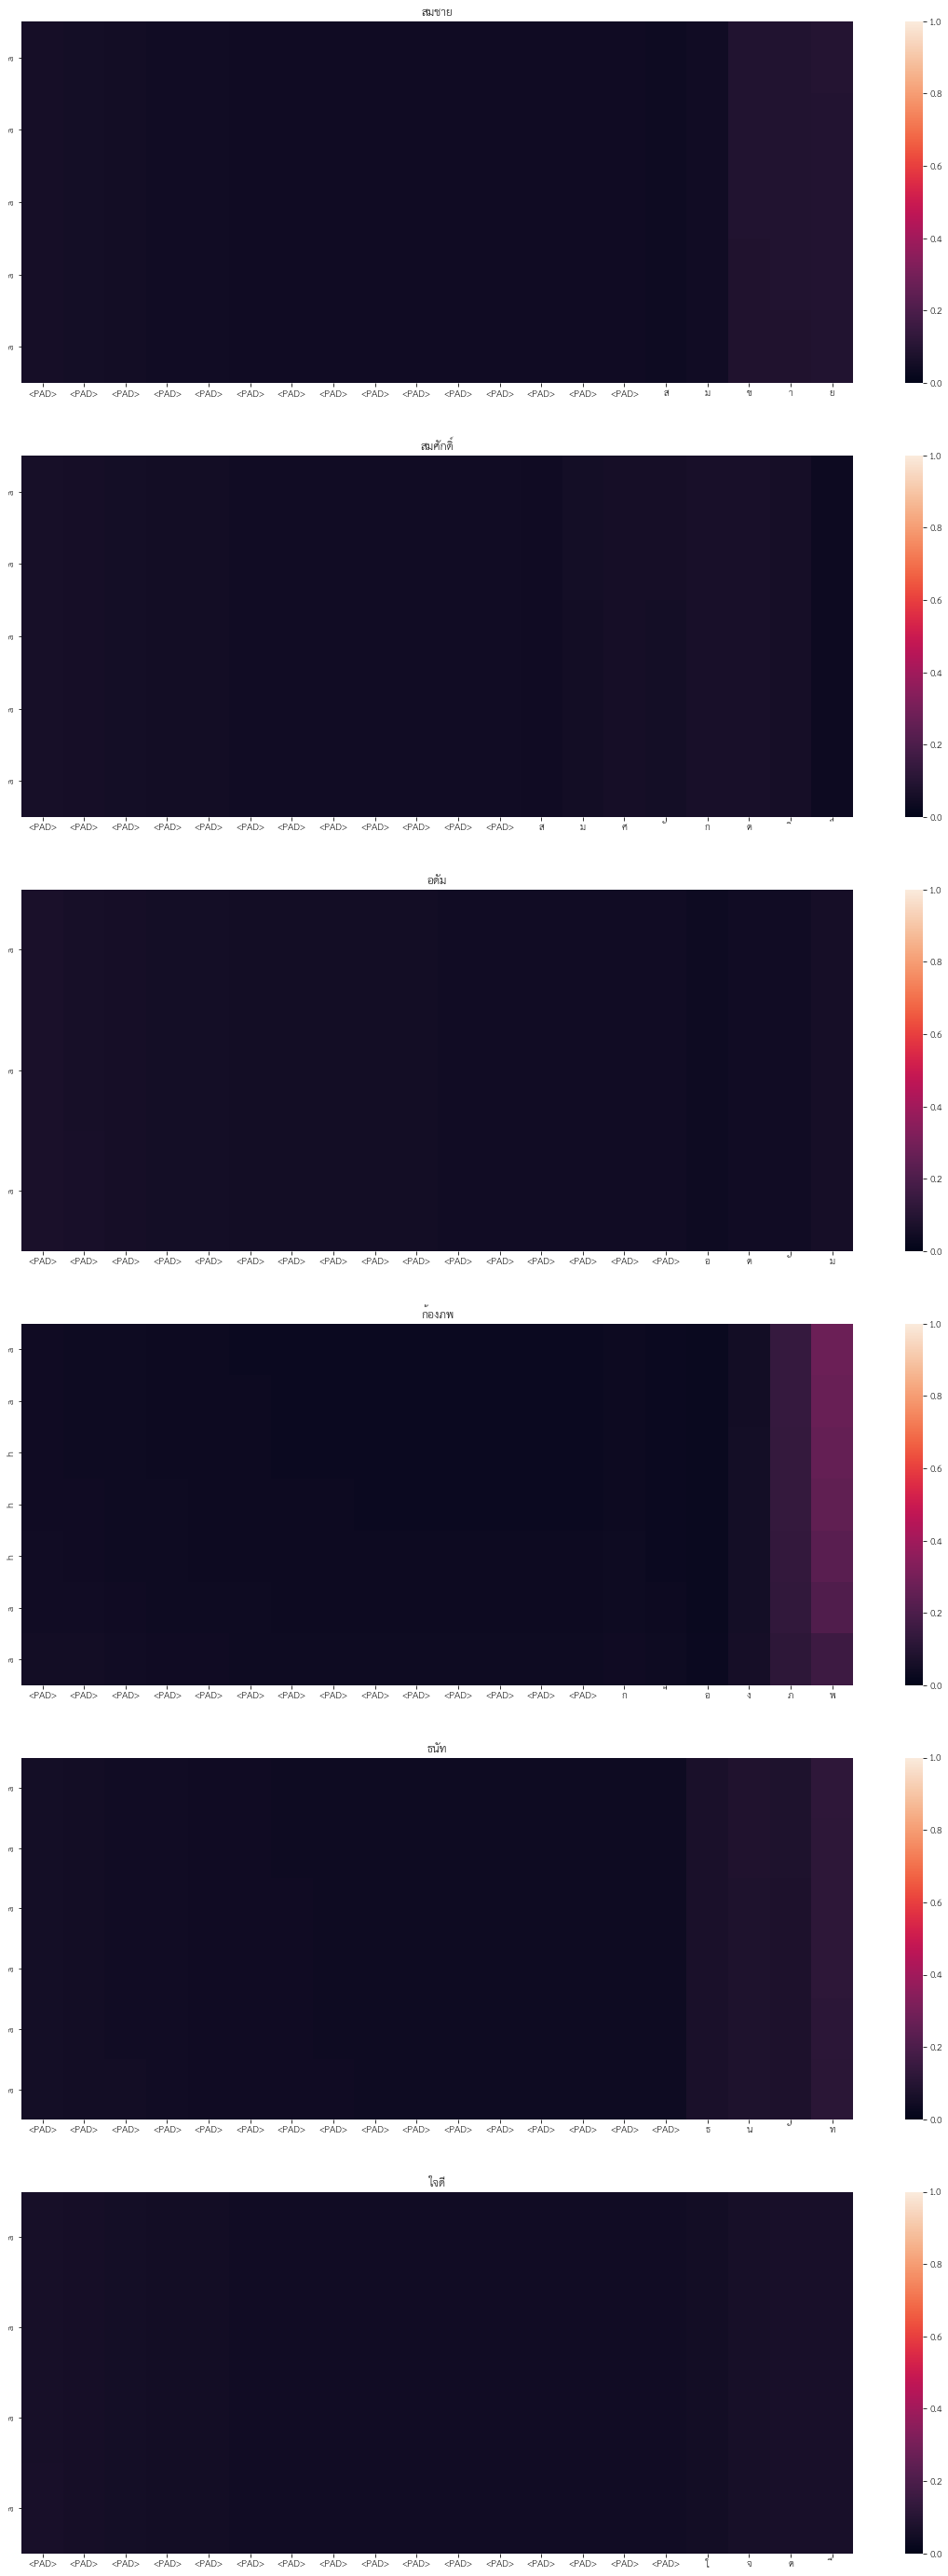

In [23]:
def plotheat(output_list,atten):
    fig, ax = plt.subplots(nrows = 6, figsize=(20,50))
    for index,i in enumerate(output_list) :
        word = i[0]
        word_padded = ['<PAD>']*(maxlen_in - len(word[0])) + list(word[0])
        start,end = get_word_indices(i[1])
        att = atten[index]
        a = att.reshape(30,20)
        a = a[start:end,:]
        out = list(filter((lambda x : x != "<PAD>" and x != "<END>" ),i[1]) )
        sns.heatmap(a,xticklabels=word_padded, yticklabels=out, vmin=0, vmax=1 , ax=ax[index])
        ax[index].set_title(word[0])
    plt.show()
print(output_list[0][1])
start,end = get_word_indices(output_list[0][1])
print(start,end)
plotheat(output_list,attention_list)